## P P1.Regresión

***

**1.** Primeramente se importan todas las liberías necesarias para la ejecución del código.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

***

**2.** Se carga la base de datos que se estará utilizando, la cual incluye datos escolares de los estudiantes en la educación secundaria. Esta cuenta con información demográfica, rendimiento académico y condiciones sociales, entre otros.

Así mismo, se describe la base de datos imprimiendo el total de cantidad de observaciones y de variables, así como los nombres de cada una de estas. Se imprimen también el tipo de datos de cada variable.

En un archivo a parte se encuentra el diccionario de la base de datos el cual describe cada variable.

Al estar trabajando con información académica y obervar la gráfica generada, me pareció que una regresión lineal puede ser pertinente tomando en cuenta que factores afectan a la variable de salida, para este caso la calificación final. Además, se explorará si algún tipo de regresión no lineal, como la polinómica se ajustaría mejor a estos datos.

Cantidad de observaciones: 649
Cantidad de variables: 34
Nombres de las variables: ['School', 'Gender', 'Age', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Education', 'Father_Education', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School', 'Guardian', 'Travel_Time', 'Study_Time', 'Number_of_Failures', 'School_Support', 'Family_Support', 'Extra_Paid_Class', 'Extra_Curricular_Activities', 'Attended_Nursery', 'Wants_Higher_Education', 'Internet_Access', 'In_Relationship', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Weekday_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade', 'Dropped_Out']
School                         object
Gender                         object
Age                             int64
Address                        object
Family_Size                    object
Parental_Status                object
Mother_Education                int64
Father_Education                int64
Mother

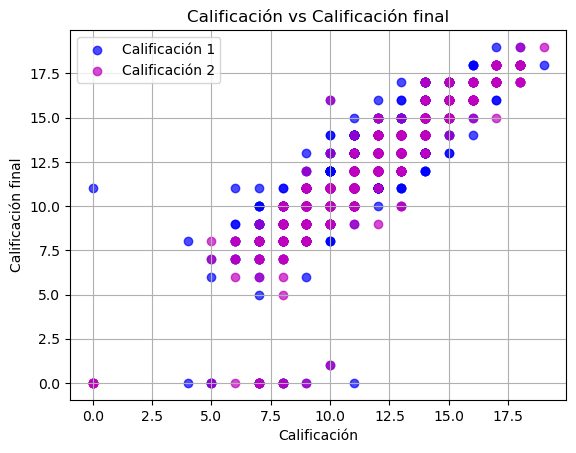

In [7]:
datos = pd.read_csv('student dropout.csv')

print(f'Cantidad de observaciones: {datos.shape[0]}')
print(f'Cantidad de variables: {datos.shape[1]}')

print(f'Nombres de las variables: {datos.columns.tolist()}')
print(datos.dtypes)

plt.scatter(datos["Grade_1"], datos["Final_Grade"],label="Calificación 1",color='b', alpha=0.7)
plt.scatter(datos["Grade_2"], datos["Final_Grade"], color='m',alpha=0.7,label="Calificación 2")
plt.xlabel("Calificación")
plt.ylabel("Calificación final")
plt.title("Calificación vs Calificación final")
plt.legend()
plt.grid(True)
plt.show()

***

**3.** Se aplican soluciones para los problemas de variables cualitativas, colinealidad e interacciones. 

Se transforman las variables categóricas con el objetivo que los nuevos datos sean útiles para el modelo de regresión. 

Se genera una matriz de correlaciones y un heatmap para encontrar de una manera más sencilla potenciales problemas de colinealidad.

Se incluyen términos de interacción para los pares de variables: *Grade_1_Grade_2* y *Travel_time_Number_of_Absences*. Luego, se imprimen las primeras 5 observaciones. Esto  se realiza con la intención de conocer la interacción entre dichas variables.

   Age  Mother_Education  Father_Education  Travel_Time  Study_Time  \
0   18                 4                 4            2           2   
1   17                 1                 1            1           2   
2   15                 1                 1            1           2   
3   15                 4                 2            1           3   
4   16                 3                 3            1           2   

   Number_of_Failures  Family_Relationship  Free_Time  Going_Out  \
0                   0                    4          3          4   
1                   0                    5          3          3   
2                   0                    4          3          2   
3                   0                    3          2          2   
4                   0                    4          3          2   

   Weekend_Alcohol_Consumption  ...  Guardian_mother  Guardian_other  \
0                            1  ...             True           False   
1                   

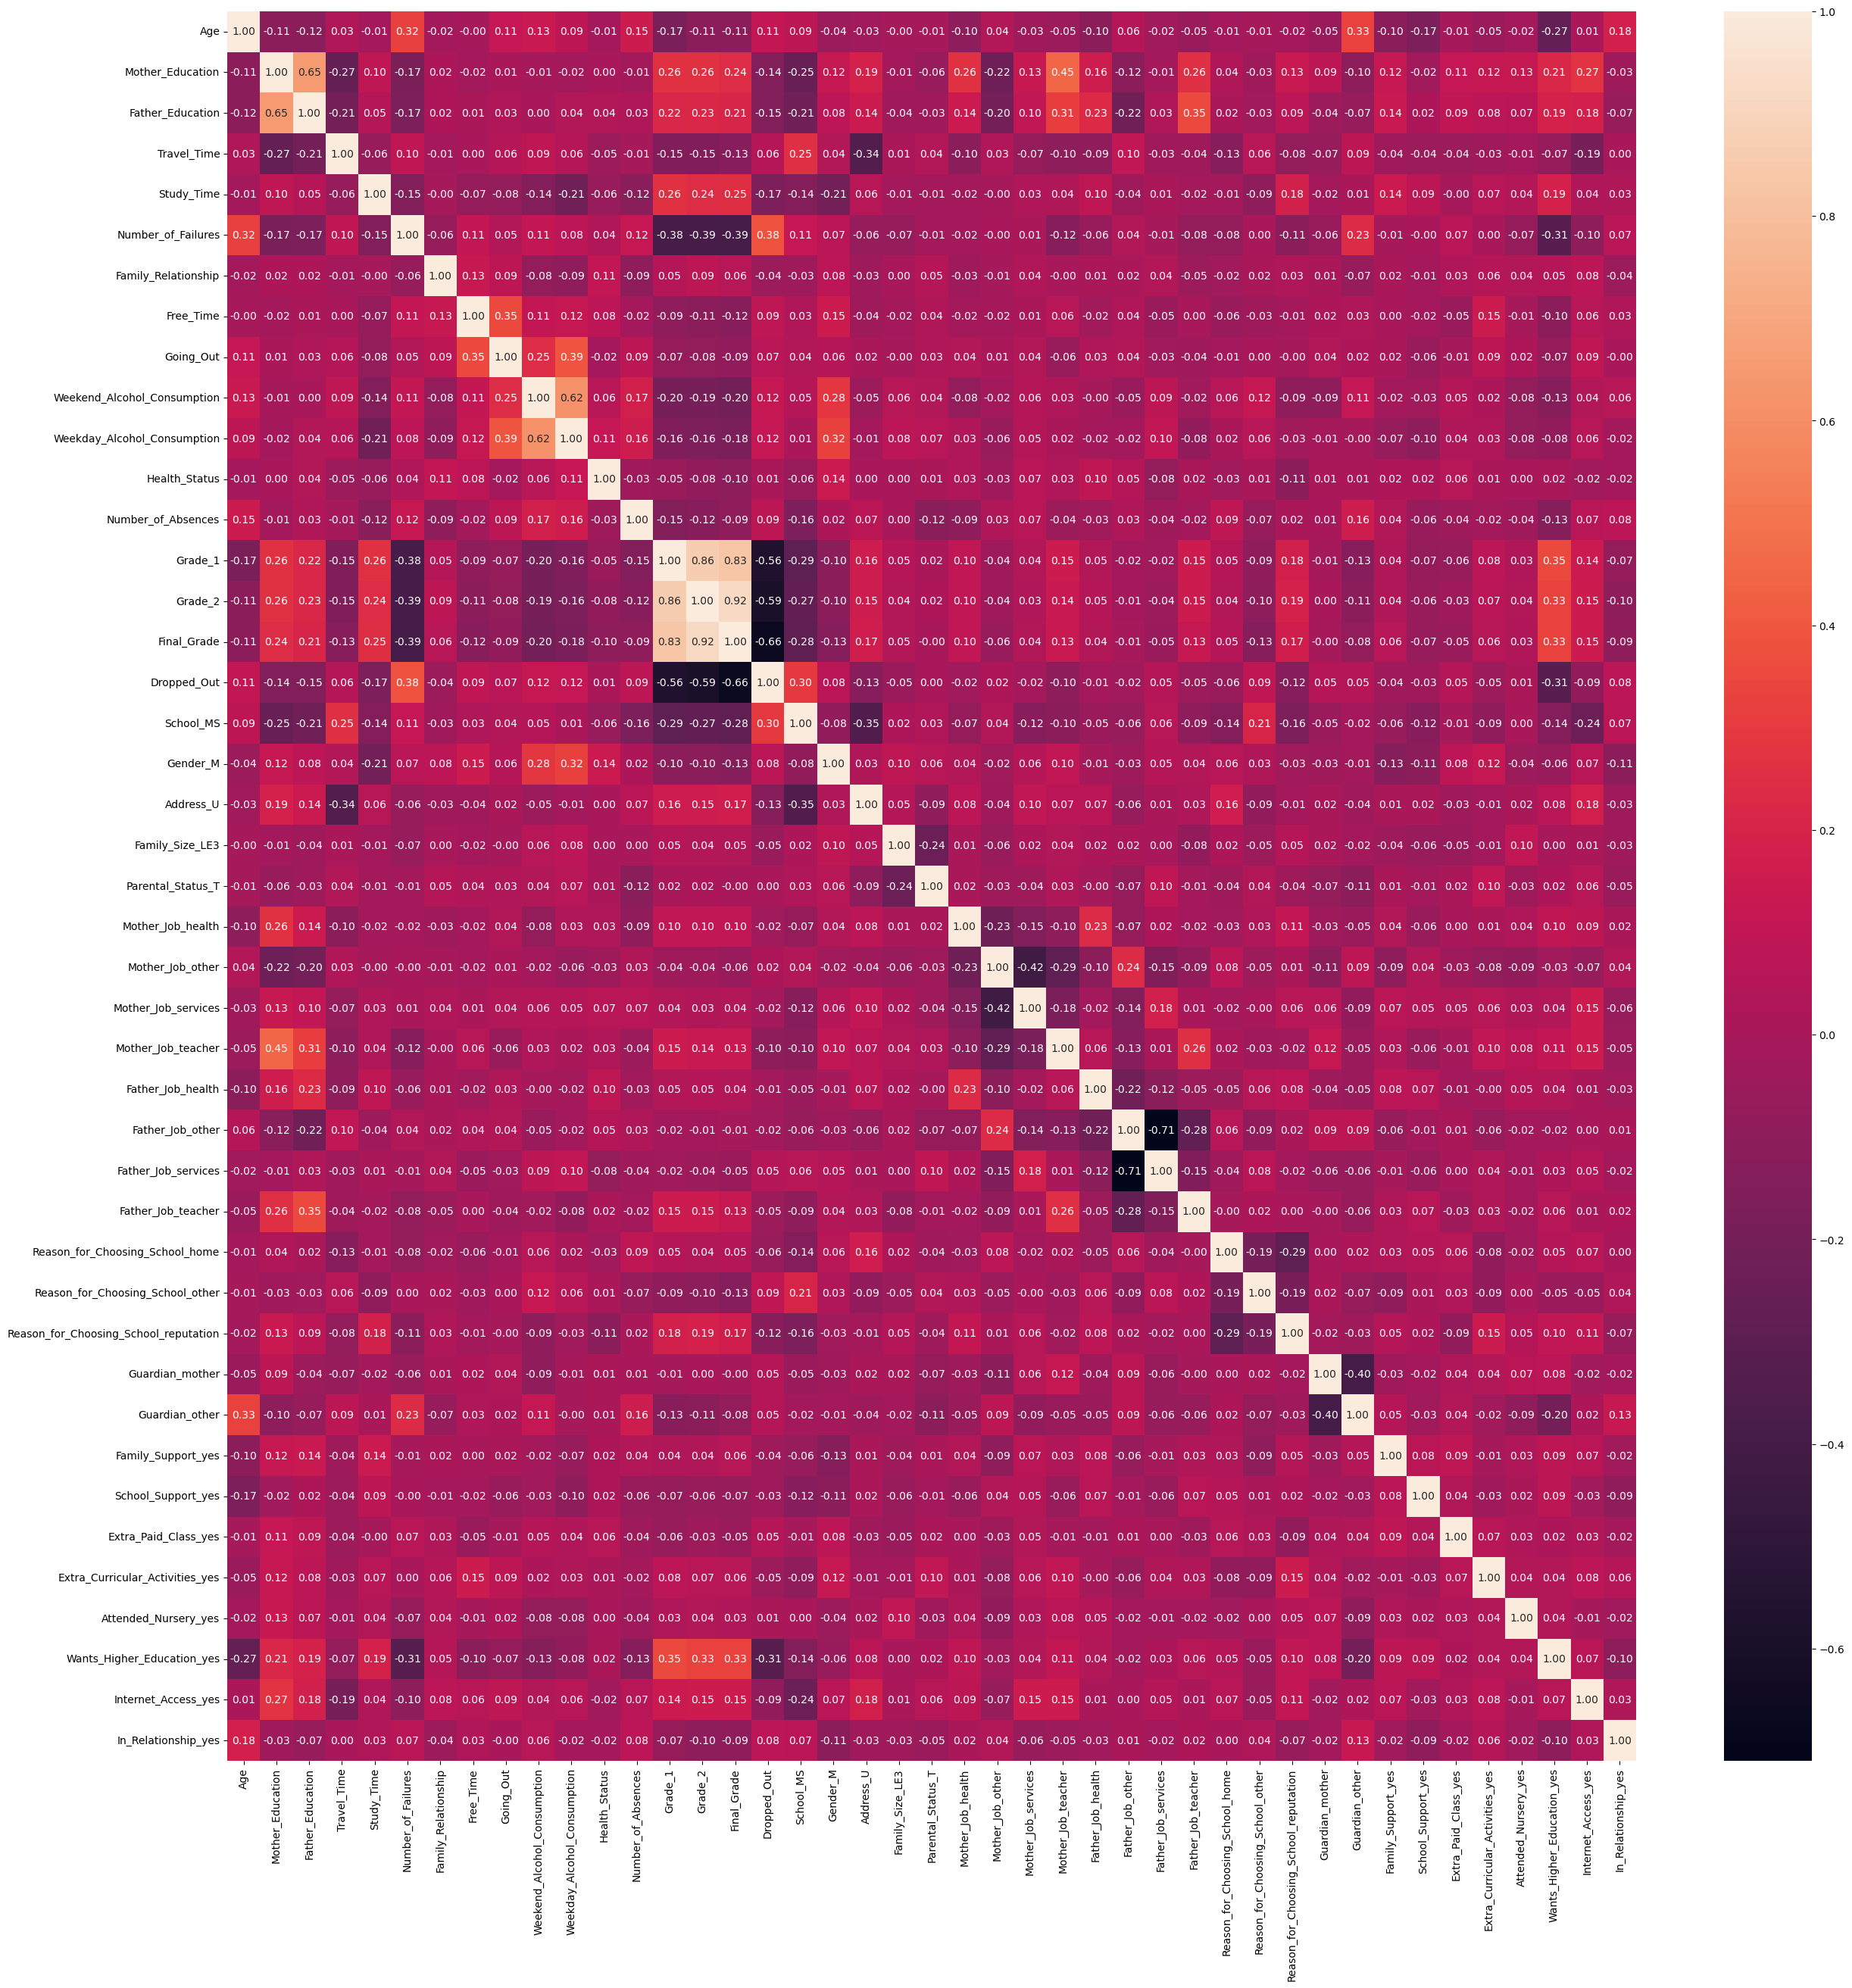

In [10]:
# Variables categóricas
datos = pd.get_dummies(datos, columns=[
    "School", "Gender", "Address", "Family_Size", "Parental_Status",
    "Mother_Job", "Father_Job", "Reason_for_Choosing_School", "Guardian",
    "Family_Support", "School_Support", "Extra_Paid_Class",
    "Extra_Curricular_Activities", "Attended_Nursery", "Wants_Higher_Education",
    "Internet_Access", "In_Relationship"
], drop_first=True)
print(datos.head(5))

# Colinealidad
correlation_matrix = datos.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

# Interacciones
datos["Grade_1_Grade_2"] = datos["Grade_1"] * datos["Grade_2"]
datos["T_N"] = datos["Travel_Time"] * datos["Number_of_Absences"]

***

**4.** Se definen la variable objetivo (y) que para este caso, como se mencionó anteriormente es la Calificación final.

In [13]:
x = datos.drop(columns=["Final_Grade"])
y = datos["Final_Grade"]

***

**5.** Se divide de manera aleatoria la base de datos en datos de entrenamiento y prueba con una relación 80/20.

Adicionalmente se imprime el número de datos de entrenamiento y de prueba a utilizar, así como el total de estos.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Observaciones datos de entrenamiento: {x_train.shape}")
print(f"Observaciones datos de prueba: {x_test.shape}")
print(f'Total de observaciones en entrenamiento y prueba: {x_train.shape[0]+x_test.shape[0]}')

Observaciones datos de entrenamiento: (519, 44)
Observaciones datos de prueba: (130, 44)
Total de observaciones en entrenamiento y prueba: 649


***

**6.** Se continua con una selección de características mixta, donde se decide aplicar primero un proceso de selección hacia adelante, luego hacia atrás. Se decide utilizar una selección mixta para analizar cual de ambas arroja un mejor valor de ajuste a los datos.

In [19]:
modelo = LinearRegression()

max_features = min(20, x_train.shape[1])
min_features = min(8, x_train.shape[1])

seleccion_adelante = SFS(modelo, k_features=(min_features, max_features), forward=True, scoring='r2', cv=10)
seleccion_adelante.fit(x_train, y_train)

caracteristicas_seleccionadas = list(x_train.columns[list(seleccion_adelante.k_feature_idx_)])
print("Nombres de las características seleccionadas (adelante):", caracteristicas_seleccionadas)

x_train_seleccion = x_train[caracteristicas_seleccionadas]
modelo.fit(x_train_seleccion, y_train)

x_test_seleccion = x_test[caracteristicas_seleccionadas]
y_prediccion = modelo.predict(x_test_seleccion)

max_features_atras = min(10, x_train_seleccion.shape[1])
min_features_atras = min(2, x_train_seleccion.shape[1])

seleccion_atras = SFS(modelo, k_features=(min_features_atras, max_features_atras), forward=False, scoring='r2', cv=10)
seleccion_atras.fit(x_train_seleccion, y_train)

caracteristicas_seleccionadas_atras = list(x_train_seleccion.columns[list(seleccion_atras.k_feature_idx_)])
print("Nombres de las características seleccionadas (atrás):", caracteristicas_seleccionadas_atras)

x_train_seleccion_atras = x_train[caracteristicas_seleccionadas_atras]
modelo.fit(x_train_seleccion_atras, y_train)

x_test_seleccion_atras = x_test[caracteristicas_seleccionadas_atras]
y_prediccion_atras = modelo.predict(x_test_seleccion_atras)

lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
caracteristicas_lasso = x_train.columns[lasso.coef_ != 0]
print("Características seleccionadas con Lasso:", list(caracteristicas_lasso))

Nombres de las características seleccionadas (adelante): ['Family_Relationship', 'Health_Status', 'Grade_1', 'Grade_2', 'Dropped_Out', 'Mother_Job_health', 'Mother_Job_services', 'Family_Support_yes', 'Extra_Paid_Class_yes']
Nombres de las características seleccionadas (atrás): ['Family_Relationship', 'Health_Status', 'Grade_1', 'Grade_2', 'Dropped_Out', 'Mother_Job_health', 'Mother_Job_services', 'Family_Support_yes', 'Extra_Paid_Class_yes']
Características seleccionadas con Lasso: ['Mother_Education', 'Travel_Time', 'Study_Time', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Dropped_Out', 'School_MS', 'Gender_M', 'Address_U', 'Family_Size_LE3', 'Mother_Job_health', 'Mother_Job_other', 'Mother_Job_services', 'Father_Job_services', 'Reason_for_Choosing_School_other', 'Reason_for_Choosing_School_reputation', 'Guardian_other', 'Family_Support_yes', 'School_Support_yes', 'Extra_Paid_Class_yes',

***

**7.** Se realiza un regresión no lineal. Para este caso se eligió una regresión polinómica de grado 2. Para esta también se calculó su R^2, esto con el objetivo de observar diferencias de ajuste y ver cual de los modelos es mejor para estos datos.

In [22]:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

modelo_polinomico = LinearRegression()
modelo_polinomico.fit(x_train_poly, y_train)
y_pred_polinomico = modelo_polinomico.predict(x_test_poly)

***

**8.** Como métricas de error se incluye la R^2 y MSE (Error cuádratico medio).

In [25]:
R2 = r2_score(y_test, y_prediccion)
print("R2 prueba (selección adelante):", R2)
mse_lineaal = mean_squared_error(y_test, y_prediccion)
print(f"MSE Regresión Lineal: {mse_lineaal:.4f}")

R2_atras = r2_score(y_test, y_prediccion_atras)
print("R2 prueba (selección atrás):", R2_atras)
mse_lineal = mean_squared_error(y_test, y_prediccion_atras)
print(f"MSE Regresión Lineal: {mse_lineal:.4f}")

if R2 > R2_atras:
    print("El modelo con selección adelante tiene mejor desempeño con un R2 de", R2, "comparado con", R2_atras, "del modelo con selección atrás.")
elif R2_atras > R2:
    print("El modelo con selección atrás tiene mejor desempeño con un R2 de", R2_atras, "comparado con", R2, "del modelo con selección adelante.")
else:
    print("Ambos modelos tienen el mismo desempeño con un R2 de", R2)

R2_polinomico = r2_score(y_test, y_pred_polinomico)
print(f"R2 para regresión polinómica: {R2_polinomico}")
mse = mean_squared_error(y_test, y_pred_polinomico)
print(f"MSE (Error cuadrático medio): {mse:.4f}")

R2 prueba (selección adelante): 0.8704937286785502
MSE Regresión Lineal: 1.2629
R2 prueba (selección atrás): 0.8704937286785502
MSE Regresión Lineal: 1.2629
Ambos modelos tienen el mismo desempeño con un R2 de 0.8704937286785502
R2 para regresión polinómica: 0.2729697501131263
MSE (Error cuadrático medio): 7.0898


Esto indica que el modelo de regresión lineal explica aproximadamente el 87% de la variabilidad en la variable respuesta (calificación final). Un R^2  alto sugiere que el modelo tiene un buen ajuste a los datos. Además, el MSE bajo (1.2629) indica que el error cuadrático medio es relativamente pequeño, lo que sugiere una buena capacidad predictiva.

Este modelo presenta un R2 mucho menor en comparación con la regresión lineal, lo que indica que no captura bien la variabilidad de los datos. Además, el MSE es mucho más alto, lo que confirma que la predicción tiene mayor error. Esto sugiere que una regresión polinómica no es una buena opción para este conjunto de datos.

***

**9.** Se genera una vez más un modelo, pero para realizar un análisis de inferencia. 

In [29]:
x_train_numeric = x_train.astype(float)
x_test_numeric = x_test.astype(float)

X_const = sm.add_constant(x_train_numeric)
modelo_inferencia = sm.OLS(y_train, X_const).fit()
print(modelo_inferencia.summary())
print("Intervalos de confianza:")
print(modelo_inferencia.conf_int(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:            Final_Grade   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     75.99
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          4.46e-186
Time:                        15:21:40   Log-Likelihood:                -805.90
No. Observations:                 519   AIC:                             1702.
Df Residuals:                     474   BIC:                             1893.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

A partir de esto, se obtiene un valor de R^2=0.876 y un estadístico F < 0.05, indicando que al menos existe una variable significativa respecto a la salida de este modelo.

Observando los coeficientes obtenidos, con base al valor p, se obtienen que las variables con una asociación estadísticamente significativa son *Grade_2*, *Dropped_Out* con la Calificación final. El estado de abandono escolar (Dropped_Out) también es un factor significativo. Esto puede implicar que los estudiantes que han abandonado la escuela tienen un impacto significativo en la calificación final.

Por otro lado, factores como la *Edad*, *Weekend_Alcohol_Consumption*,*Weekday_Alcohol_Consumption*, entre otros, no muestran una relación estadísticamente significativa con la calificación final.

***

**10.** Se gráfican los resultados obtenidos de la regresión lineal y de la polinómica. 

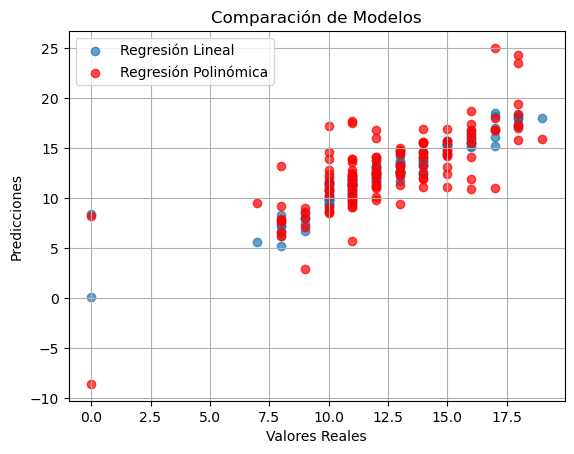

In [33]:
plt.scatter(y_test, y_prediccion, alpha=0.7, label="Regresión Lineal")
plt.scatter(y_test, y_pred_polinomico, alpha=0.7, color='r', label="Regresión Polinómica")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación de Modelos")
plt.legend()
plt.grid(True)
plt.show()

***

**Conclusión** 
La regresión lineal obtiene un valor de R^2 ajustado mayor a la regresión no lineal, mostrando una mejor explicación de la variación de los datos. Así mismo, los valores del MSE también indican que el modelo con mejor ajuste es el de la regresión lineal. Con esto es posible determinar que para estos datos en particular, un modelo de regresión lineal sería la mejor opción.